#Идентификация интернет-пользователей.


Данный проект посвящен задаче идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. Если выразить идею данной задачи в краткой форме, то она состоит в том, что взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду.

В данном проекте будет решаться похожая задача: необходимо проанализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определить, Элис это (истинный пользователь) или взломщик (кто-то другой). Этой задаче посвящено [соревнование](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) на Kaggle, откуда и будут взяты исходные данные, и где будет проводиться итоговая оценка качества построенной модели.

#### Цель проекта:
Построение модели, способной определить по последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, является ли пользователь истинным или ложным (взломщиком).

#### Задачи проекта:
 - Описать исходные данные;
 - Произвести первичный анализ признаков;
 - Произвести визуальный анализ признаков;
 - Создать дополнительные признаки;
 - Обучить модель и подобрать параметры;
 - Написать вывод.

# Импорт данных

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
import os
import pickle

import itertools
from scipy.sparse import csr_matrix, hstack
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")

from datetime import datetime
import time
from collections import Counter

In [ ]:
# Путь к данным 
PATH_TO_DATA = ('drive/My Drive/DS/identification/')

#Предобработка

In [ ]:
def transforming_data(path_to_csv_files, 
                                    session_length=10, window_size=10):

  files = [file for file in os.listdir(path_to_csv_files+'/') if file[-4:] == '.csv']

  users = pd.DataFrame()

  id_of_users = []
  for file in files:
      num = file[4:8]
      #считываем пользователя
      current_data = pd.read_csv(path_to_csv_files+'/'+file, parse_dates=['timestamp']).assign(user_id = num)
      #переносим индексы в лист
      ind = current_data.index.tolist()
      #создаём подсписки с сессиями по принципу скользящего окна
      sessions = [ind[x : x + session_length] for x in range(0, len(ind), window_size)]
      #сглаживаем список
      flat_list = [item for sublist in sessions for item in sublist]    
      #выводим df с сайтами-дубликатами, относящимися к нескольким сессиям
      current_data = current_data.iloc[flat_list]
      # в каждом подлисте листа sessions заменяем все его значения на индекс подлиста
      for i in range(len(sessions)):
          sessions[i] = [i+1]*len(sessions[i])
      #присваиваем номера сессий
      current_data['session_id'] = [item for sublist in sessions for item in sublist]
      #создаём пустой df; копируем наш df вместе со сбросом индексов; присваиваем его в переменную, соответсвующую id юзера
      globals()[str(file[:-4])] = pd.DataFrame().append(current_data, ignore_index=True)
      #добавляем в список названием переменных в формате str
      id_of_users.append(str(file[:-4]))
      #конкатенируем все df - с помощью eval переводим str в названия переменных
  users = pd.concat([eval(i) for i in id_of_users]) 

  #считаем частоту встречаемости сайтов
  sitecnt = Counter()
  for i in users.site.values.tolist():
      sitecnt[i] += 1
  
  #переводим в словарь и сортируем по уменьшению встречаемости
  freqlist = sorted(list(sitecnt.items()), key=lambda x: x[1],reverse=True)
  
  #присваиваем id-номера сайтам
  site_id_dict= {}
  for i in range(len(freqlist)):
      site_id_dict[freqlist[i][0]] = i + 1
  
  #собираем единый словарь с id и встречаемостью
  sites = dict()
  for i in range(len(freqlist)):
      sites[freqlist[i][0]] = (site_id_dict[freqlist[i][0]], freqlist[i][1])
  
  #заменяем названия сайтов на их id-номера
  vals = list(users.site.values)
  for i in range(len(vals)):
      vals[i] = str(sites[vals[i]][0])
  users.site = vals

  users['sec'] = pd.to_datetime(users.timestamp, infer_datetime_format=False).values.astype(np.int64)  // 10 ** 9
  users['time'] = users.timestamp

  grouped_df = users.groupby(['session_id', 'user_id'])['site', 'sec', 'time'].agg({'site': list, 'sec': list, 'time': list})


  #Дополнительные признаки
  grouped_df['time_first'] = grouped_df['sec'].apply(lambda x: pd.to_datetime(x[0], unit='s'))
  grouped_df['start_hour'] = grouped_df['time_first'].dt.hour 
  grouped_df['day_of_week'] = grouped_df['time_first'].dt.dayofweek
  grouped_df['morning'] = ((grouped_df['start_hour'] >= 7) & (grouped_df['start_hour'] <= 11)).astype('int')
  grouped_df['day']= ((grouped_df['start_hour'] >= 12) & (grouped_df['start_hour'] <= 18)).astype('int')
  grouped_df['evening'] = ((grouped_df['start_hour'] >= 19) & (grouped_df['start_hour'] <= 23)).astype('int')
  grouped_df['night'] = ((grouped_df['start_hour'] >= 0) & (grouped_df['start_hour'] <= 6)).astype('int')



  #создаём датафрейм, где рядам соответствует номер сессии, а столбцам - номер сайта в сессии; недостающие значения заменяем нулём
  sites_id = pd.DataFrame([tuple(i) for i in grouped_df.site.values], 
                          columns=['site'+ str(i+1) for i in range(session_length)]).fillna(0)
  time_diff = pd.DataFrame([tuple(i) for i in grouped_df.sec.apply(lambda t: [j-i for i, j in zip(t[:-1], t[1:])]).values],
                          columns=['time_diff'+ str(i+1) for i in range(session_length - 1)]).fillna(0)
  times = pd.DataFrame([tuple(i) for i in grouped_df.time.values], 
                          columns=['time'+ str(i+1) for i in range(session_length)]).fillna(pd.NaT)                       
  
  grouped_df = pd.concat([sites_id, time_diff,times, grouped_df.reset_index()], axis=1)

  #ещё признаки

  media_checker = ['plus.google.com', 'twitter.com', 'www.facebook.com','facebook.com', 'www.google.dz',
            'youtube.fr', 'youtube.com', 'instagram.com', 'www.reddit.com', 's.youtube.com',
            'www.youtube.com', 'reddit.com', 'connect.facebook.net', 'platform.twitter.com']
  google_checker = ['www.google.fr', 'www.google.com', 'www.google.dz', 'www.google.com.pe', 'google.fr', 
            'google.com', 'www.google.dz']

  media = list(filter(lambda x: x[0] in media_checker, [i for i in list(site_id_dict.items())]))
  google = list(filter(lambda x: x[0] in google_checker, [i for i in list(site_id_dict.items())]))

  id_of_media = [str(i[1]) for i in media]
  id_of_google = [str(i[1]) for i in google]

  red_df = grouped_df[grouped_df.columns[:window_size]]

  m_counter,g_counter, i_counter = [], [], []
  #Проход через цикл
  for i in range(grouped_df.shape[0]):
      m_counter.append(len(list(filter(lambda x: x in id_of_media, red_df.iloc[i].values))))
      g_counter.append(len(list(filter(lambda x: x in id_of_google, red_df.iloc[i].values))))
      i_counter.append(list(i[0] for i in filter(
          lambda x: x[1] in id_of_media, enumerate(red_df.iloc[i].values))))
      
  grouped_df['social_media'] = m_counter
  grouped_df['google'] = g_counter
  grouped_df['indexes'] = i_counter


  #продолжительность сессии
  train_durations = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int)
  scaler = StandardScaler()
  train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1,1))
  grouped_df['session_duration'] = pd.Series(train_dur_scaled.flatten())


  #количество уникальных сайтов в сессии
  def nunique(a, axis):
    return (np.diff(np.sort(a,axis=axis),axis=axis)!=0).sum(axis=axis)+1

  grouped_df['unique_sites'] = nunique(sites_id.astype(int), axis=1) - 1

  # Месяц и год
  grouped_df['month'] = times['time1'].apply(lambda t: t.month)
  # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
  grouped_df['year_month'] = times['time1'].apply(lambda t: 100 * t.year + t.month) / 1e2

  grouped_df = grouped_df.sort_values(by=['user_id', 'session_id']).set_index('session_id')
  grouped_df.drop(columns=['site', 'sec', 'time', 'time_first', 'indexes'], inplace=True)
  grouped_df = grouped_df
  
  return grouped_df, site_id_dict

In [ ]:
%%time
df10, dict10 = transforming_data(os.path.join(PATH_TO_DATA,'10users'))

CPU times: user 9.06 s, sys: 261 ms, total: 9.32 s
Wall time: 9.09 s


In [ ]:
df10.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,user_id,start_hour,day_of_week,morning,day,evening,night,social_media,google,session_duration,unique_sites,month,year_month
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,192,574,133,3,133,133,3,133,203,133,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,2013-11-15 08:12:07,2013-11-15 08:12:17,2013-11-15 08:12:17,2013-11-15 08:12:17,2013-11-15 08:12:18,2013-11-15 08:12:38,2013-11-15 08:12:39,2013-11-15 08:12:39,2013-11-15 08:12:40,2013-11-15 08:12:40,0031,8,4,1,0,0,0,0,2,-0.086809,4,11,201.311
2,415,193,674,254,133,31,393,3305,217,55,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,2013-11-15 08:12:40,2013-11-15 08:12:41,2013-11-15 08:12:41,2013-11-15 08:15:24,2013-11-15 08:17:09,2013-11-15 08:17:09,2013-11-15 08:17:10,2013-11-15 08:17:13,2013-11-15 08:17:16,2013-11-15 08:17:24,0031,8,4,1,0,0,0,0,0,-0.084196,9,11,201.311
3,55,3,55,55,5,293,415,333,897,55,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,2013-11-15 08:17:25,2013-11-15 08:17:25,2013-11-15 08:17:39,2013-11-15 08:17:40,2013-11-15 08:21:42,2013-11-15 08:21:42,2013-11-15 08:21:42,2013-11-15 08:21:43,2013-11-15 08:21:43,2013-11-15 08:21:43,0031,8,4,1,0,0,0,1,1,-0.084466,6,11,201.311
4,473,3306,473,55,55,55,55,937,199,123,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,2013-11-15 08:21:43,2013-11-15 08:21:45,2013-11-15 08:21:46,2013-11-15 08:21:46,2013-11-15 08:21:47,2013-11-15 08:22:12,2013-11-15 08:22:13,2013-11-15 08:22:13,2013-11-15 08:22:13,2013-11-15 08:22:13,0031,8,4,1,0,0,0,0,0,-0.086841,5,11,201.311
5,342,55,5,3307,258,211,3308,2086,675,2086,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2013-11-15 08:22:13,2013-11-15 08:22:14,2013-11-15 08:22:14,2013-11-15 08:22:15,2013-11-15 08:22:16,2013-11-15 08:22:17,2013-11-15 08:22:17,2013-11-15 08:22:18,2013-11-15 08:22:19,2013-11-15 08:22:19,0031,8,4,1,0,0,0,1,0,-0.087091,8,11,201.311


#Визуальный анализ

In [ ]:
counts = pd.DataFrame(df10['user_id'].value_counts(normalize=True)).reset_index()
counts.columns = ['user', 'share']

Распределение пользователей в датасете

In [ ]:
fig = px.pie(counts, values='share', names='user', title='Distribution of users in dataset')
fig.update_layout(width=500, height=500)
fig.show()

Распределение длительности сессий по пользователям

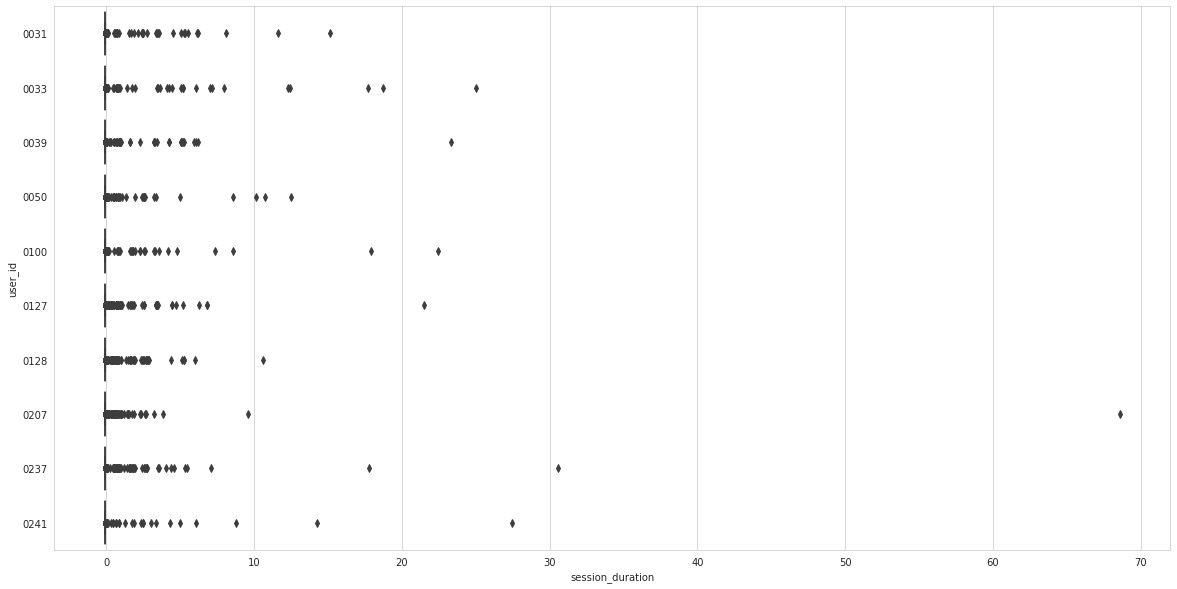

In [ ]:
plt.subplots(figsize=(20,10))
sns.boxplot(x='session_duration', y='user_id', data=df10)

Боксплоты демонстрируют огромное количество сильных выбросов в продолжительности сессий.  
Это, скорее всего, обусловлено методом преобразования данных, при котором сайты, на которые пользователь заходил с интервалом во многие дни, оказывались в одной сессии.  
Полезность этого признака под вопросом. 

Распределение часов, в которые заходили пользователи

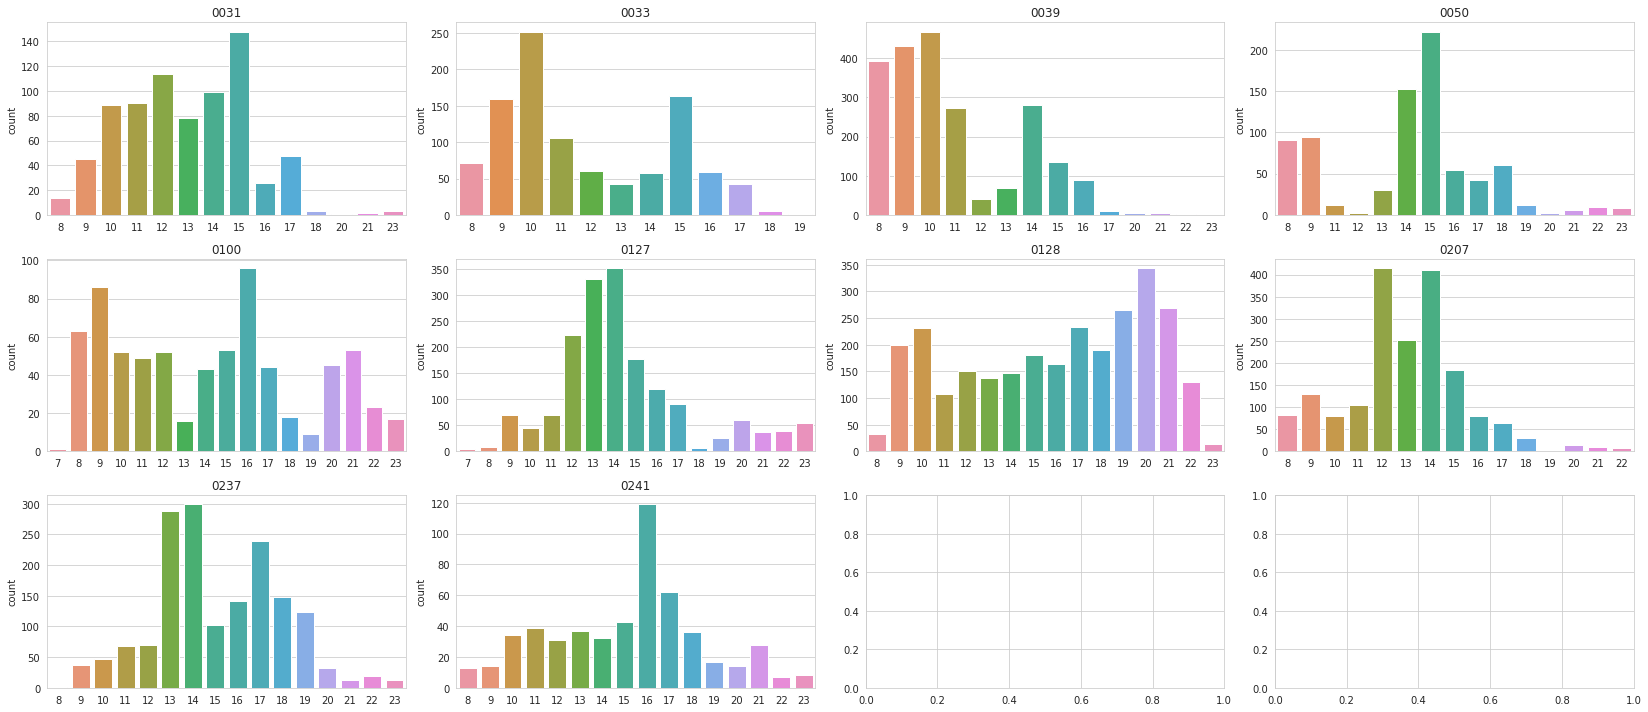

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(23,10))
user_ids = df10['user_id'].unique()
for num, axis in enumerate(axes.flat):
  id = user_ids[num]
  sns.countplot(x='start_hour', data=df10.query('user_id == @id'), 
                ax=axis)
  axis.xaxis.label.set_visible(False)
  axis.set_title(id)
  if num == user_ids.shape[0]-1:
    break
fig.tight_layout()

Распределение месяцов, в которые заходили пользователи

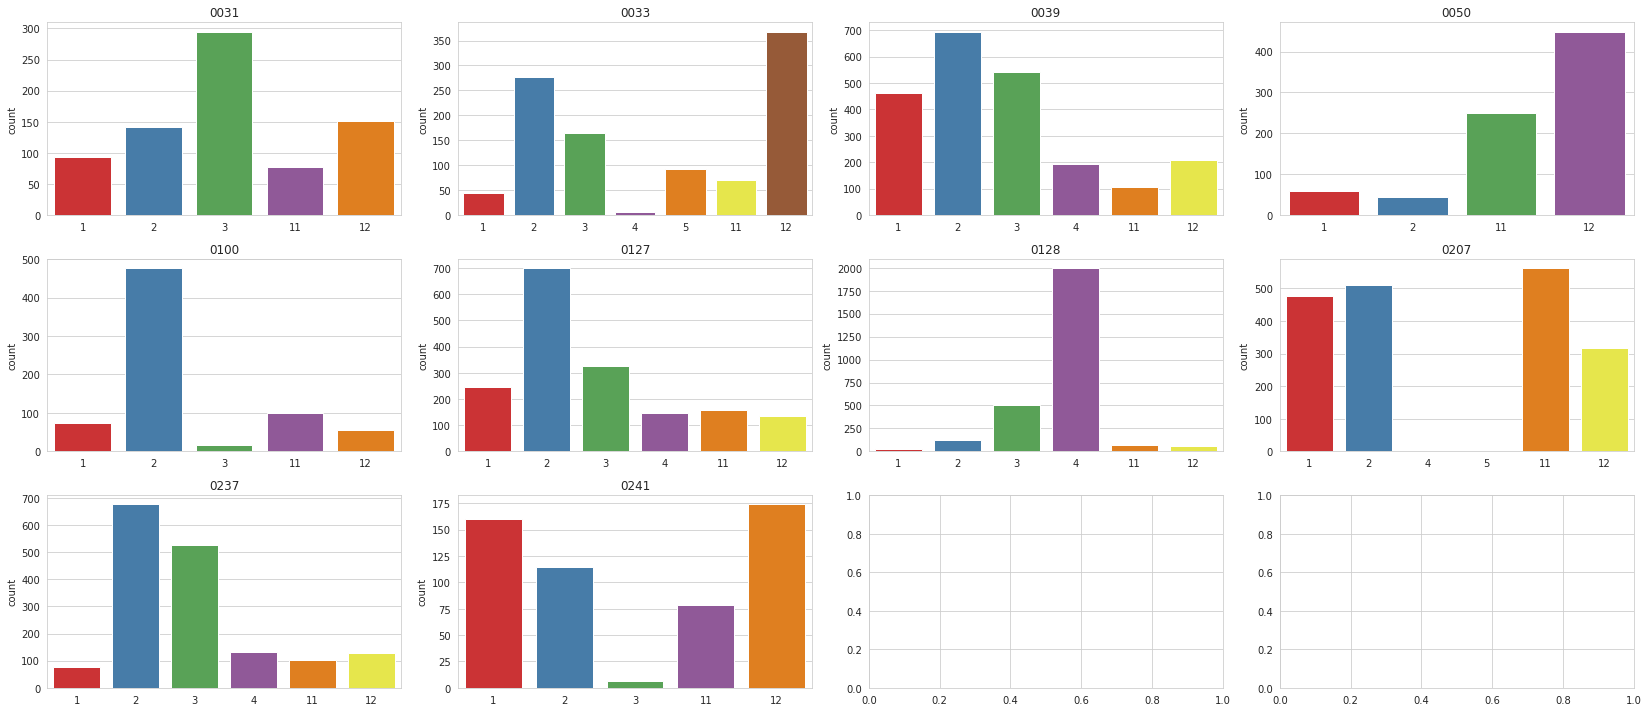

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(23,10))
user_ids = df10['user_id'].unique()
for num, axis in enumerate(axes.flat):
  id = user_ids[num]
  sns.countplot(x='month', data=df10.query('user_id == @id'), palette='Set1',
                ax=axis)
  axis.xaxis.label.set_visible(False)
  axis.set_title(id)
  if num == user_ids.shape[0]-1:
    break
fig.tight_layout()

Распределение дней недели, в которые заходили пользователи

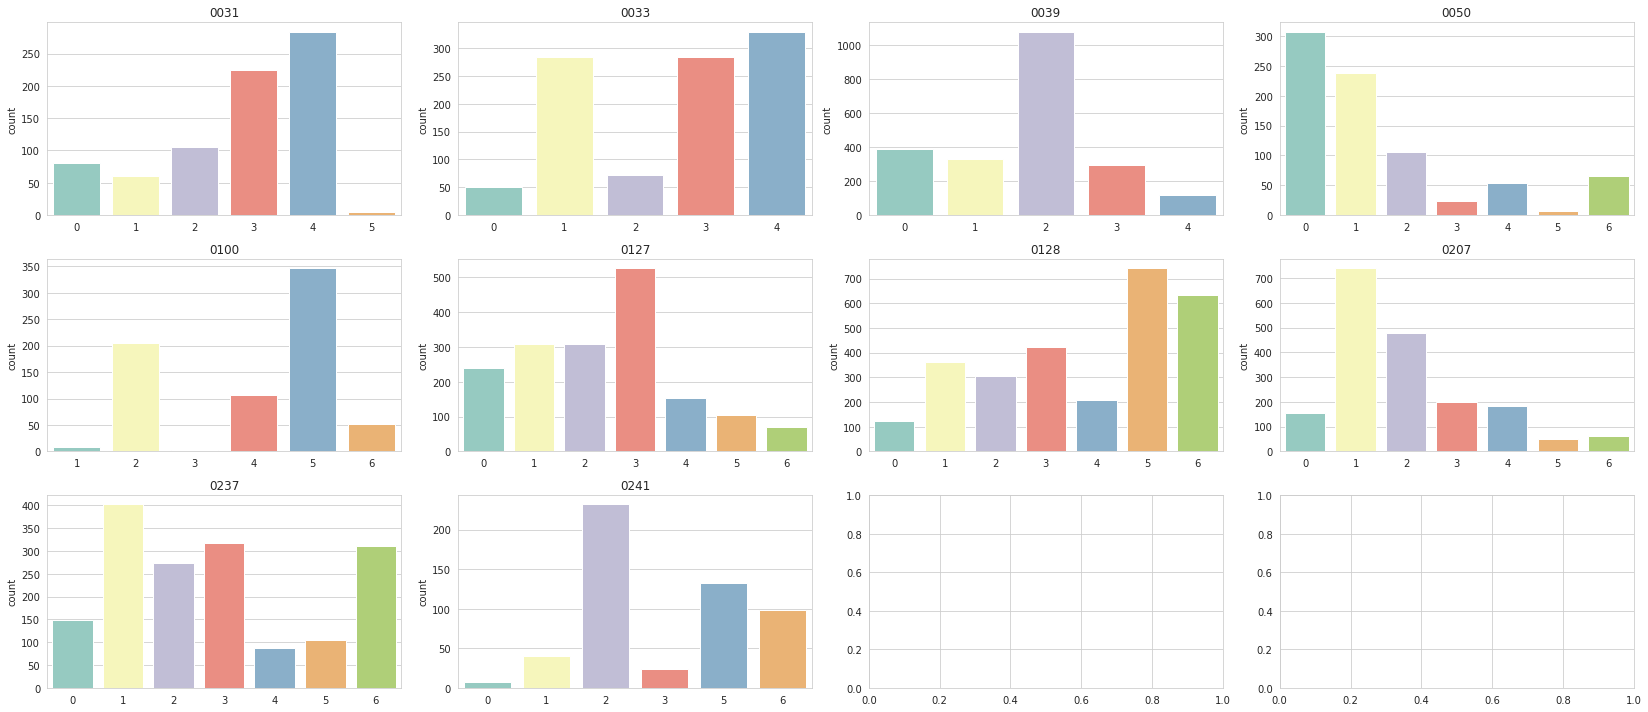

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(23,10))
user_ids = df10['user_id'].unique()
for num, axis in enumerate(axes.flat):
  id = user_ids[num]
  sns.countplot(x='day_of_week', data=df10.query('user_id == @id'), palette='Set3',
                ax=axis)
  axis.xaxis.label.set_visible(False)
  axis.set_title(id)
  if num == user_ids.shape[0]-1:
    break
fig.tight_layout()

Более точное распределение дат по юзерам

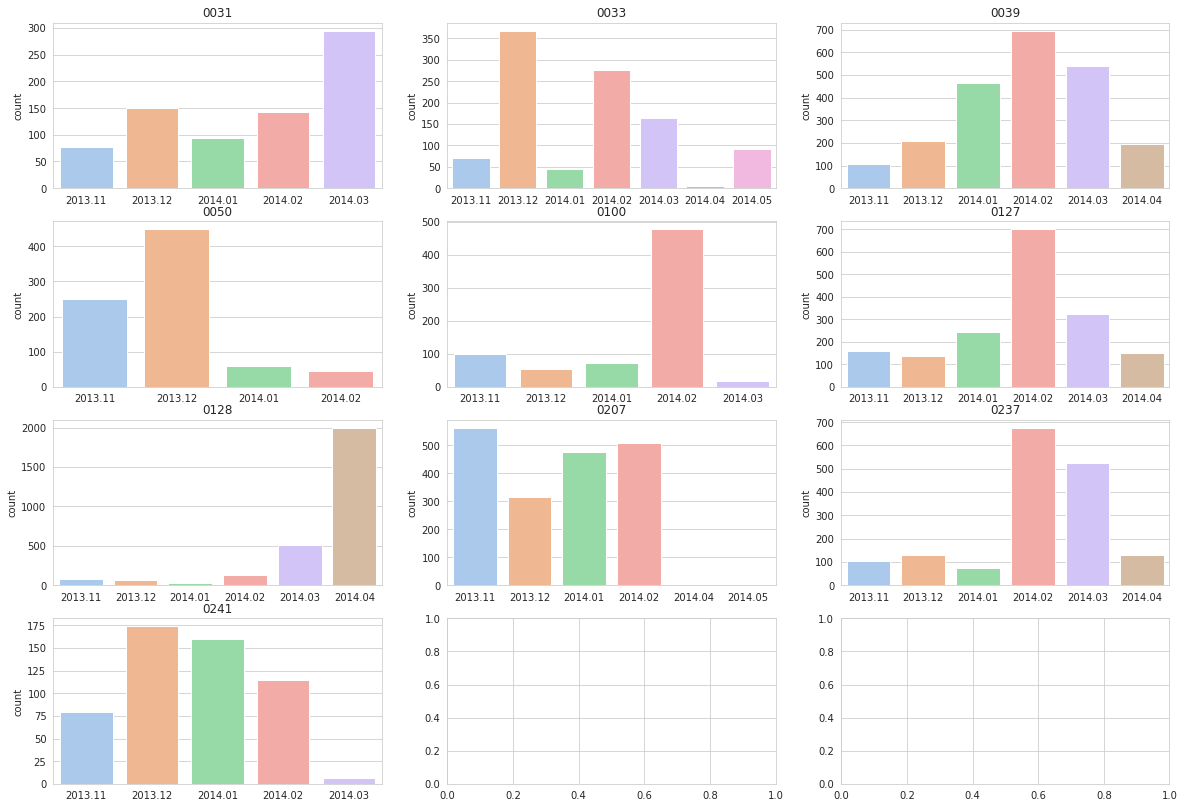

In [ ]:
kfig, axes = plt.subplots(4,3, figsize=(20,14))
user_ids = df10['user_id'].unique()
for num, axis in enumerate(axes.flat):
  id = user_ids[num]
  sns.countplot(x='year_month', data=df10.query('user_id == @id'), palette='pastel',
                ax=axis)
  axis.xaxis.label.set_visible(False)
  axis.set_title(id)
  if num == user_ids.shape[0]-1:
    break
fig.tight_layout()

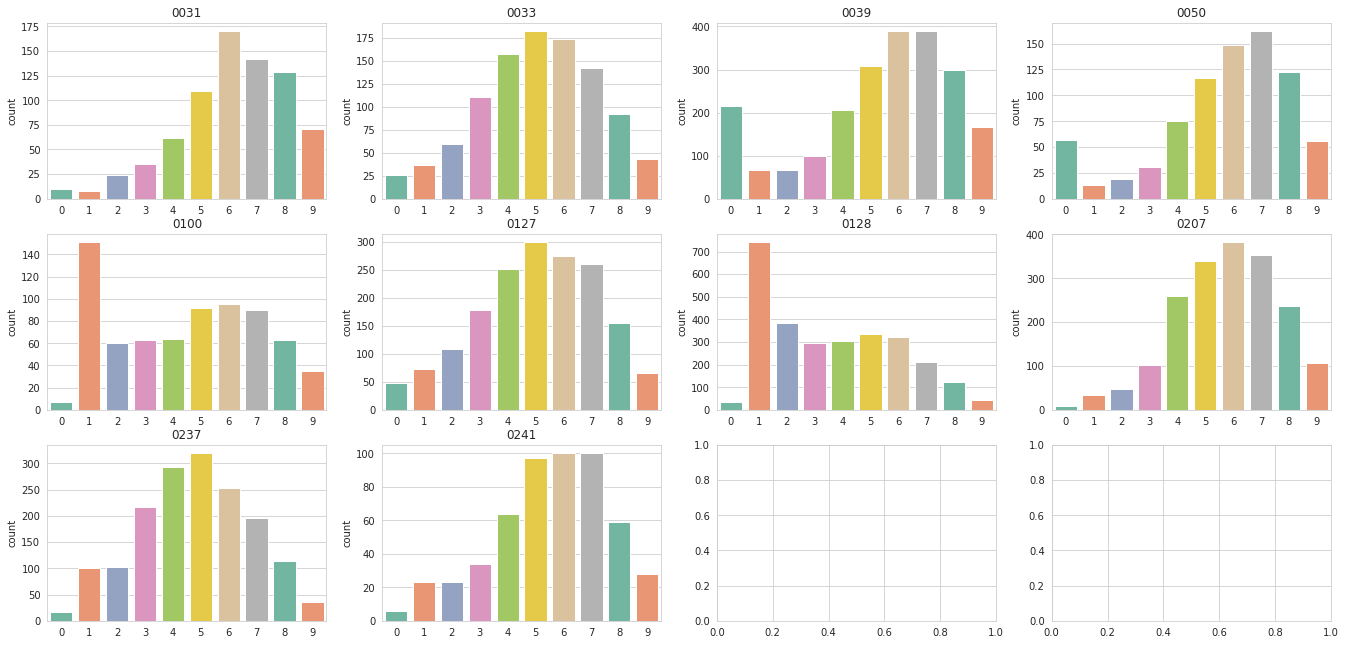

In [ ]:
kfig, axes = plt.subplots(3,4, figsize=(23,11))
user_ids = df10['user_id'].unique()
for num, axis in enumerate(axes.flat):
  id = user_ids[num]
  sns.countplot(x='unique_sites', data=df10.query('user_id == @id'), palette='Set2',
                ax=axis)
  axis.xaxis.label.set_visible(False)
  axis.set_title(id)
  if num == user_ids.shape[0]-1:
    break
fig.tight_layout()

In [ ]:
mean_sites = df10.groupby(['user_id'])[['google', 'social_media']].mean().reset_index()

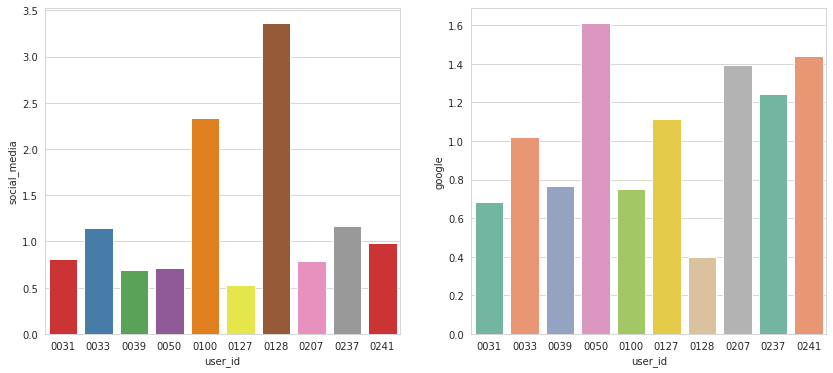

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
sns.barplot(x='user_id', y='social_media', data=mean_sites, palette='Set1', ax=ax[0])
sns.barplot(x='user_id', y='google', data=mean_sites, palette='Set2', ax=ax[1])

#Model fitting for 10 users

Здесь будем перебирать наиболее полезные признаки 

In [ ]:
df10, dict10 = transforming_data(os.path.join(PATH_TO_DATA,'10users'))

In [ ]:
class DataPreparator(BaseEstimator, TransformerMixin):
    """
    Fill NaN with zero values.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        sites = list(filter(lambda x: 'site' in x, X.columns))
        return X[sites].fillna(0).astype('int')

class ListPreparator(BaseEstimator, TransformerMixin):
    """
    Prepare a CountVectorizer friendly 2D-list from data.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.values.tolist()
        # Convert dataframe rows to strings
        return [" ".join([str(site) for site in row]) for row in X]

class AttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new attributes to training and test set.
    """

    def fit(self, X, y=None):
        return self 
      
    def transform(self, X, y=None):
        # intraday features
        hour = X['time1'].apply(lambda ts: ts.hour)
        morning = ((hour >= 7) & (hour <= 11)).astype('int')
        day = ((hour >= 12) & (hour <= 18)).astype('int')
        evening = ((hour >= 19) & (hour <= 23)).astype('int')
        night = ((hour >= 0) & (hour <= 7)).astype('int')
        
        # season features
        month = X['time1'].apply(lambda ts: ts.month)
        
        # day of the week features
        weekday = X['time1'].apply(lambda ts: ts.weekday()).astype('int')
        
        # year features
        year = X['time1'].apply(lambda ts: ts.year).astype('int')

        #number_of_unique_sites in session
        def nunique(a, axis):
          return (np.diff(np.sort(a,axis=axis),axis=axis)!=0).sum(axis=axis)+1

        unique_sites = pd.get_dummies(nunique(np.array(X[list(filter(lambda x: 'site' in x, X.columns))].astype(int).fillna(0)), axis=1) - 1)

        X = np.c_[
                  # morning.values, day.values, evening.values, night.values,
                  pd.get_dummies(hour),
                  pd.get_dummies(month),
                  pd.get_dummies(weekday),
                  unique_sites.values
                  ]
        return X

class ScaledAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new features, that should be scaled.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # X = X.astype(int)
        # session time features
        times = list(filter(lambda x: 'time' in x, X.columns))

        # session duration: take to the power of 1/5 to normalize the distribution
        session_duration = (X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]').astype(int) ** 0.2

        # number_of_sites = np.count_nonzero(np.array(X[times]), axis=1)

        # average time spent on one site during a session
        # time_per_site = (session_duration / number_of_sites) ** 0.2
        
        social_media = X['social_media']

        google = X['google']

        X = np.c_[session_duration.values,
                  social_media.values,
                  google.values,
                  # number_of_sites, 
                  # time_per_site.values
                  ]
        return X

vectorizer_pipeline = Pipeline([
    ("preparator", DataPreparator()),
    ("list_preparator", ListPreparator()),
    ("vectorizer", TfidfVectorizer(ngram_range=(1, 10), max_features=50000, sublinear_tf=True))
])

attributes_pipeline = Pipeline([
    ("adder", AttributesAdder())
])

scaled_attributes_pipeline = Pipeline([
    ("adder", ScaledAttributesAdder()),
    ("scaler", StandardScaler())
])

full_pipeline = FeatureUnion(transformer_list=[
  ('vectorizer_pipeline', vectorizer_pipeline),
  ('attributes_pipeline', attributes_pipeline),
  ('scaled_attributes_pipeline', scaled_attributes_pipeline)
], n_jobs=-1)

In [ ]:
%%time
X_10 = full_pipeline.fit_transform(df10)
y_10 = df10["user_id"].astype('int').values

CPU times: user 3.28 s, sys: 172 ms, total: 3.45 s
Wall time: 9.07 s


In [ ]:
%%time
skfold = StratifiedKFold(shuffle=True, random_state=42)

logit = LogisticRegression(C=1, solver='sag',
                           n_jobs=-1, multi_class='multinomial',
                           random_state=42)
cv_scores = cross_val_score(logit, X_10, y_10, cv = skfold,
                        scoring='f1_weighted',
                         n_jobs=-1, verbose=0)

print(cv_scores.mean())
print(cv_scores.std())
print(cv_scores)

0.8207158283280951
0.0060651214867907645
[0.82025699 0.81843391 0.82434742 0.82935131 0.81118951]
CPU times: user 104 ms, sys: 20.3 ms, total: 124 ms
Wall time: 12.9 s


## Window/Session combinations

Теперь посмотрим на наиболее удачную комбинацию длины сессии и длины окна.

In [ ]:
session_sizes = [5, 7, 10, 15]
window_sizes = [5, 7, 10, 15]
combs =[(x,y) for x in window_sizes for y in session_sizes]
combs = list(filter(lambda x: x[0] <= x[1], combs))

In [ ]:
def session_window_check(session_length, window_size):

  df10_sample, dict10_sample = transforming_data(os.path.join(PATH_TO_DATA,'10users'), session_length, window_size)

  X_sample = full_pipeline.fit_transform(df10_sample)
  y_sample = df10_sample["user_id"].astype('int').values

  skfold = StratifiedKFold(shuffle=True, random_state=42)

  logit = LogisticRegression(C=1, solver='sag',
                            n_jobs=-1, multi_class='multinomial',
                            random_state=42)
  cv_scores = cross_val_score(logit, X_sample, y_sample, cv = skfold,
                          scoring='f1_weighted',
                          n_jobs=-1, verbose=0)

  return cv_scores.mean()

In [ ]:
cv_results = []

for w_size, s_length in combs:
  print('Window size is', w_size, '; Session length is', s_length)
  print('In process...')
  print()

  result = session_window_check(s_length, w_size)

  print('Mean cv-score is ', result)
  print()
  cv_results.append([(w_size, s_length), result])
  print('Completed! Next...')
  print()
  print()

Window size is 5 ; Session length is 5
In process...

Mean cv-score is  0.8017112560758125

Completed! Next...


Window size is 5 ; Session length is 7
In process...

Mean cv-score is  0.8400370563112951

Completed! Next...


Window size is 5 ; Session length is 10
In process...

Mean cv-score is  0.8824828292159262

Completed! Next...


Window size is 5 ; Session length is 15
In process...

Mean cv-score is  0.9260712716999008

Completed! Next...


Window size is 7 ; Session length is 7
In process...

Mean cv-score is  0.8109068814570743

Completed! Next...


Window size is 7 ; Session length is 10
In process...

Mean cv-score is  0.854734949084038

Completed! Next...


Window size is 7 ; Session length is 15
In process...

Mean cv-score is  0.8971278897951678

Completed! Next...


Window size is 10 ; Session length is 10
In process...

Mean cv-score is  0.8207158283280951

Completed! Next...


Window size is 10 ; Session length is 15
In process...

Mean cv-score is  0.867441923045407

In [ ]:
sorted(cv_results, key=lambda x: x[1], reverse=True)

[[(5, 15), 0.9260712716999008],
 [(7, 15), 0.8971278897951678],
 [(5, 10), 0.8824828292159262],
 [(10, 15), 0.867441923045407],
 [(7, 10), 0.854734949084038],
 [(5, 7), 0.8400370563112951],
 [(10, 10), 0.8207158283280951],
 [(15, 15), 0.8180743212296943],
 [(7, 7), 0.8109068814570743],
 [(5, 5), 0.8017112560758125]]

Наиболее удачная комбинация длины сессии и размера скользящего окна:  
5 - длина окна  
15- длина сессии

## LogisticRegressionCV

Здесь мы будем определять наиболее подходящий признак C для логистической регрессии

In [ ]:
df10_15_5, dict10 = transforming_data(os.path.join(PATH_TO_DATA,'10users'), 15, 5)

In [ ]:
%%time
X_10_15_5 = full_pipeline.fit_transform(df10)
y_10_15_5 = df10["user_id"].astype('int').values

CPU times: user 2.68 s, sys: 164 ms, total: 2.84 s
Wall time: 8.14 s


In [ ]:
skfold = StratifiedKFold(shuffle=True)
logitcv = LogisticRegressionCV(cv=skfold, scoring='f1_weighted', multi_class='multinomial', solver='sag',
                               n_jobs=-1,  verbose=0)
logitcv.fit(X_10_15_5, y_10_15_5)

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=None, refit=True,
                     scoring='f1_weighted', solver='sag', tol=0.0001,
                     verbose=0)

In [ ]:
print('Best C is:', logitcv.C_[0])

Best C is: 166.81005372000558


Сузим пространство для поиска наиболее оптимального значения С

In [ ]:
logitcv.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [ ]:
skfold = StratifiedKFold(shuffle=True)
logitcv_precise = LogisticRegressionCV(
    #задаём более узкое пространство для поиска
    Cs=np.linspace(1.66810054e+02, 1.00000000e+04, num=20),
    cv=skfold, scoring='f1_weighted', multi_class='multinomial', solver='sag',
                               n_jobs=-1,  verbose=0)
logitcv_precise.fit(X_10_15_5, y_10_15_5)

LogisticRegressionCV(Cs=array([  166.810054  ,   684.34636695,  1201.88267989,  1719.41899284,
        2236.95530579,  2754.49161874,  3272.02793168,  3789.56424463,
        4307.10055758,  4824.63687053,  5342.17318347,  5859.70949642,
        6377.24580937,  6894.78212232,  7412.31843526,  7929.85474821,
        8447.39106116,  8964.92737411,  9482.46368705, 10000.        ]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=None, refit=True,
                     scoring='f1_weighted', solver='sag', tol=0.0001,
                     verbose=0)

In [ ]:
print('Best C is:', logitcv_precise.C_[0])

Best C is: 684.3463669473684


Теперь оценим метрику на лучших параметрах

In [ ]:
%%time
skfold = StratifiedKFold(shuffle=True, random_state=42)

logit = LogisticRegression(C=684.346, solver='sag',
                           n_jobs=-1, multi_class='multinomial',
                           random_state=42)
cv_scores = cross_val_score(logit, X_10_15_5, y_10_15_5, cv = skfold,
                        scoring='f1_weighted',
                         n_jobs=-1, verbose=0)

print(cv_scores.mean())
print(cv_scores.std())
print(cv_scores)

0.8574713320546856
0.00429071320592963
[0.86070225 0.85250631 0.85859618 0.86304426 0.85250767]
CPU times: user 116 ms, sys: 10.2 ms, total: 126 ms
Wall time: 12.5 s


##Linear SVC

Протестируем работу метода опорных векторов и посмотрим на метрику

In [ ]:
%%time
svm = LinearSVC(random_state=42, )

cv_scores_svm = cross_val_score(svm, X_10_15_5, y_10_15_5, cv=skfold, 
                        scoring='f1_weighted', n_jobs=-1,
                        verbose=0)

print(cv_scores_svm.mean())
print(cv_scores_svm.std())
print(cv_scores_svm)

0.8639246021450653
0.004311474249920563
[0.86885055 0.85624878 0.86298929 0.86679085 0.86474355]
CPU times: user 146 ms, sys: 25.3 ms, total: 172 ms
Wall time: 18.6 s


Метрика оказалась заметно больше, чем в случае с логистической регрессией.

Найдём оптимальный параметр С для метода опорных векторов

In [ ]:
svm = LinearSVC(random_state=42, )
params_svm= {'C': np.linspace(0.01,1,10)}
grid_svm = GridSearchCV(svm, params_svm, scoring='f1_weighted', n_jobs=-1, cv=skfold, return_train_score=False)
grid_svm.fit(X_10_15_5, y_10_15_5)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=42, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [ ]:
grid_svm.best_score_, grid_svm.best_params_

(0.8641564069630718, {'C': 0.89})

##SGDClassifier

In [ ]:
%%time
sgd = SGDClassifier(random_state=42, n_jobs=-1, )

cv_scores_sgd = cross_val_score(sgd, X_10_15_5, y_10_15_5, cv=skfold, 
                        scoring='f1_weighted', n_jobs=-1,
                        verbose=0)

print(cv_scores_sgd.mean())
print(cv_scores_sgd.std())
print(cv_scores_sgd)

0.8491484337267596
0.0039573144603241425
[0.85494418 0.84715958 0.85271978 0.8448341  0.84608453]
CPU times: user 51.5 ms, sys: 7.08 ms, total: 58.6 ms
Wall time: 1.92 s


In [ ]:
sgd = SGDClassifier(random_state=42, n_jobs=-1,  )
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}
grid_sgd = GridSearchCV(sgd, params, scoring='f1_weighted', n_jobs=-1, cv=skfold, return_train_score=False)
grid_sgd.fit(X_10_15_5, y_10_15_5)

In [ ]:
grid_sgd.best_score_, grid_sgd.best_params_

(0.8561764422642293, {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'none'})

##150 users

Теперь посмотрим на метрику для 150 пользователей

In [ ]:
%%time
df150, dict150 = transforming_data(os.path.join(PATH_TO_DATA,'150users'), 15,5)

CPU times: user 3min 4s, sys: 7.39 s, total: 3min 11s
Wall time: 3min 5s


In [ ]:
%%time
X_150 = full_pipeline.fit_transform(df150)
y_150 = df150["user_id"].astype('int').values

CPU times: user 13 s, sys: 1.08 s, total: 14.1 s
Wall time: 1min 51s


In [ ]:
X_150.shape

(273957, 50049)

Теперь последовательно обучим 3 алгоритма на новых данных

In [ ]:
%%time
skfold = StratifiedKFold(shuffle=True, random_state=42)

logit = LogisticRegression(C=684.346, solver='sag',
                           n_jobs=-1, multi_class='multinomial',
                           random_state=42)
cv_scores = cross_val_score(logit, X_150, y_150, cv = skfold,
                        scoring='f1_weighted',
                         n_jobs=-1, verbose=0)

print(cv_scores.mean())
print(cv_scores.std())
print(cv_scores)

0.7975745103681431
0.0005349907936887454
[0.79839434 0.79726011 0.79713208 0.79706219 0.79802383]
CPU times: user 13.8 s, sys: 1.76 s, total: 15.5 s
Wall time: 41min 36s


In [ ]:
%%time
svm = LinearSVC(random_state=42, C=0.89 )

cv_scores_svm = cross_val_score(svm, X_150, y_150, cv=skfold, 
                        scoring='f1_weighted', n_jobs=-1,
                        verbose=0)

print(cv_scores_svm.mean())
print(cv_scores_svm.std())
print(cv_scores_svm)

0.8289412441813704
0.0010826166287471108
[0.83073378 0.82896466 0.82933903 0.82769649 0.82797226]
CPU times: user 11.2 s, sys: 1.52 s, total: 12.7 s
Wall time: 32min 6s


In [ ]:
%%time
sgd = SGDClassifier(random_state=42, n_jobs=-1, loss='perceptron')

cv_scores_sgd = cross_val_score(sgd, X_150, y_150, cv=skfold, 
                        scoring='f1_weighted', n_jobs=-1,
                        verbose=0)

print(cv_scores_sgd.mean())
print(cv_scores_sgd.std())
print(cv_scores_sgd)

0.6574379916443999
0.0036719693893907225
[0.6513286  0.65894567 0.66030561 0.65529736 0.66131272]
CPU times: user 1.49 s, sys: 352 ms, total: 1.84 s
Wall time: 4min 2s


Наилучший результат показал метод LinearSVC

# Итог

В данном проекте была построена модель, способная определить, был ли совершен взлом аккаунта веб-сервиса. Особенностью данной модели является то, что она способна определить злоумышленника, даже если он не совершил никакого вредоносного действия. Осуществляется это на основе идеи о том, что поведение взломщика на веб-сервисе будет отличаться от поведения истинного пользователя. Таким образом, данная модель может использоваться в сфере информационной безопасности для обеспечения ещё большей защиты личных данных пользователей.

При построении модели были переброваны:  


*   CountVectorizer и TfidfVectorizer с ngram_range от (1, 2) до (1,10) с различным количеством уникальных признаков
*   Переменные наиболее посещаемых Алисой сайтов и сайтов, посещаемых только ей
*   Различные комбинации переменных часа посещения, дня недели и месяца
*   Переменные длительности сессии, количества уникальных сайтов и среднего времени, проведённого на сайте
*   Количество сайтов в сессии, относящихся к социальным сетям, ютубу, а также, время, проведённое в соцсетях.
*   Такие алгоритмы, как Logistic Regression, LinearSVC, SGDClassifier
*   Такие методы кросс-валидации, как TimeSeriesSplit и StratifiedKFold

